## **Importing Modules**

In [1]:
pip install efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T

from efficientnet_pytorch import EfficientNet

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

/home/maicg/anaconda3/envs/Face-insight/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maicg/anaconda3/envs/Face-insight/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/maicg/anaconda3/envs/Face-insight/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## **Data Preprocessing**

In [6]:
#importing data

# #Dataset address
# url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)

#giving zip file name
data_dir='/home/maicg/Documents/Me/python-image-processing/transfer_learning/covid19data.zip'

#extractng data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
    zf.extractall('./data/')

#removing zip file after extraction
#!rm './data.zip' 

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

In [8]:
use_cuda

True

In [10]:
#declaring batch size
batch_size = 32

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
        ]),

    'valid':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),

    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
     }

# creating Location of data: train, validation, test
data='/home/maicg/Documents/Me/python-image-processing/transfer_learning/data'

train_path=os.path.join(data,'train')
valid_path=os.path.join(data,'test')
test_path=os.path.join(data,'valid')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [11]:
#importing the pretrained EfficientNet model

model_transfer = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features


# Defining Dense top layers after the convolutional layers
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 2),
    )
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/maicg/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [04:44<00:00, 75.2kB/s]


Loaded pretrained weights for efficientnet-b0


In [12]:
# Plotting the summary of the model

summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [13]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam classifier
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

## **Training and Validating the Model**



In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)

        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [15]:
# training the model

n_epochs=10

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 0.000062 	Validation Loss: 0.000781
Epoch: 2 	Training Loss: 0.000039 	Validation Loss: 0.000671
Epoch: 3 	Training Loss: 0.000033 	Validation Loss: 0.000466
Epoch: 4 	Training Loss: 0.000031 	Validation Loss: 0.000387
Epoch: 5 	Training Loss: 0.000026 	Validation Loss: 0.000249
Epoch: 6 	Training Loss: 0.000026 	Validation Loss: 0.000189
Epoch: 7 	Training Loss: 0.000023 	Validation Loss: 0.000149
Epoch: 8 	Training Loss: 0.000027 	Validation Loss: 0.000253
Epoch: 9 	Training Loss: 0.000024 	Validation Loss: 0.000190
Epoch: 10 	Training Loss: 0.000019 	Validation Loss: 0.000151


In [16]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

##  **Testing the Model**



In [17]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [26]:
for i in preds:
    print(i)

tensor([[0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1]], device='cuda:0')
tensor([[1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0]], device='cuda:0')
tensor([[0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
  

In [18]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

In [19]:
#Computing the accuracy
acc = accuracy_score(targets2, preds2)
print("Accuracy: ", acc)

Accuracy:  0.9675324675324676


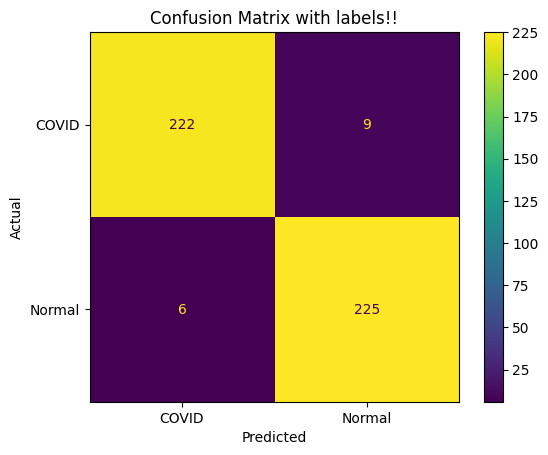

In [20]:
cm = confusion_matrix(targets2, preds2)

#Create an object for the confusion matrix display class
cmob = ConfusionMatrixDisplay(cm, display_labels=['COVID', 'Normal'])


# The plot() function has to be called for the sklearn visualization
cmob.plot()

# Use the Axes attribute 'ax_' to get to the underlying Axes object.
cmob.ax_.set(title='Confusion Matrix with labels!!', 
            xlabel='Predicted', 
            ylabel='Actual')

# Finally, call the matplotlib show() function to display the visualization
plt.show()

In [22]:
type(train_loss)

list

In [30]:
#Plotting the training loss
train_loss_plot = []
for i in train_loss:
    train_loss_plot.append(i.cpu().numpy())

train_loss_plot

[array(6.1745035e-05, dtype=float32),
 array(3.878239e-05, dtype=float32),
 array(3.259144e-05, dtype=float32),
 array(3.0769923e-05, dtype=float32),
 array(2.6025145e-05, dtype=float32),
 array(2.6454796e-05, dtype=float32),
 array(2.3165649e-05, dtype=float32),
 array(2.7418913e-05, dtype=float32),
 array(2.4161649e-05, dtype=float32),
 array(1.9166218e-05, dtype=float32)]

Text(0, 0.5, 'loss')

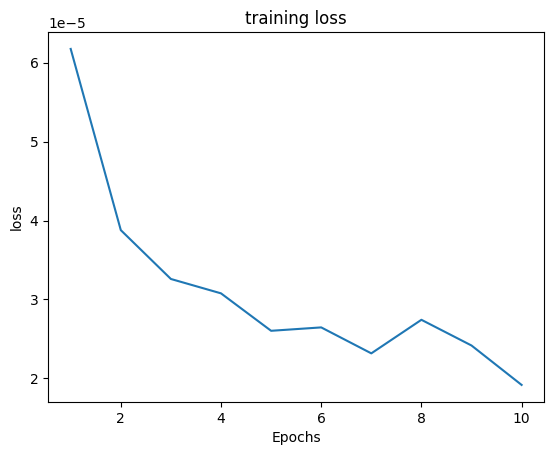

In [32]:
 
plt.plot(range(1,1+n_epochs),train_loss_plot)
plt.title("training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

In [34]:
#Plotting the valid loss
valid_loss_plot = []
for i in valid_loss:
    valid_loss_plot.append(i.cpu().numpy())

valid_loss_plot

[array(0.00078129, dtype=float32),
 array(0.00067078, dtype=float32),
 array(0.00046567, dtype=float32),
 array(0.0003867, dtype=float32),
 array(0.00024944, dtype=float32),
 array(0.00018898, dtype=float32),
 array(0.00014924, dtype=float32),
 array(0.00025344, dtype=float32),
 array(0.00019019, dtype=float32),
 array(0.00015078, dtype=float32)]

Text(0, 0.5, 'loss')

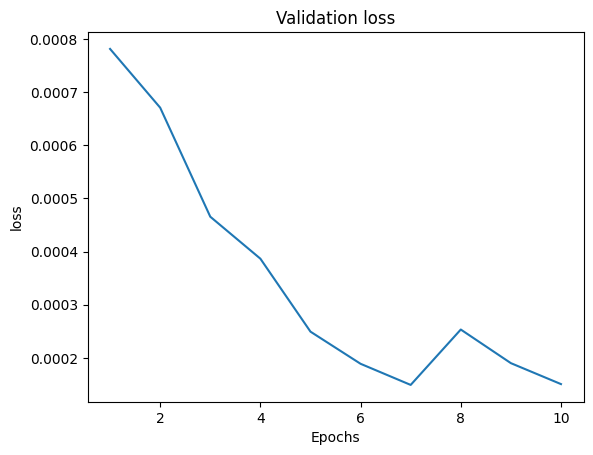

In [35]:
#Plotting the validation loss

plt.plot(range(1,1+n_epochs),valid_loss_plot)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")